In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def swapper(qobj, op2id, id2op):
    n = len(qobj.dims[0])
    index = list(range(n))
    index[op2id] = id2op
    index[id2op] = op2id
    return qobj.permute(index)
    
def unit_sizer(U,n,n_last=2,n_next=3):
    assert U.shape[0] == 2**(n_last+1)
    assert n>0 and n<=n_next
    diml = [2 for i in range(n_last+1)]
    U.dims = [diml,diml]
    Id = qt.qeye(2)
    Idl = [Id for i in range(n_next-1)]
    un = qt.tensor(U,*Idl)
    if n>1:
        un = qt.tensor(U,*Idl)
        un = swapper(un, n_last, (n_last-1)+n)
    return un

def forward(U11,U12,U13,U21,U22,pin):
    U11 = unit_sizer(U11,1,n_last=2,n_next=3)
    U12 = unit_sizer(U12,2,n_last=2,n_next=3)
    U13 = unit_sizer(U13,3,n_last=2,n_next=3)
    U21 = unit_sizer(U21,1, n_last = 3, n_next=2)
    U22 = unit_sizer(U22,2, n_last = 3, n_next=2)  
    zro = qt.fock_dm(2, 0)
    pin1 = qt.tensor(pin,zro,zro,zro)
    pin2 = U13*U12*U11*pin1*U11.dag()*U12.dag()*U13.dag()
    pint = pin2.ptrace([2,3,4])
    pint1 = qt.tensor(pint,zro,zro)
    pint2 = U22*U21*pint1*U21.dag()*U22.dag()
    pout = pint2.ptrace([3,4])
    return pin,pint,pout

def cost(outs,train_outs):
    assert len(outs) == len(train_outs)
    C = 0
    N = len(outs)
    for a,b in zip(outs,train_outs):
        C += qt.fidelity(a,b)
    return C*(1/N)

def adjoint_layer(pout, U21, U22):
    U21 = unit_sizer(U21,1, n_last = 3, n_next=2)
    U22 = unit_sizer(U22,2, n_last = 3, n_next=2)  
    Id = (1/2**3)*qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
    zz = qt.tensor(qt.fock_dm(2, 0),qt.fock_dm(2, 0))
    pout1 = qt.tensor(pout,Id)
    inter = qt.tensor(zz,Id)
    pout2 = inter*U21.dag()*U22.dag()*pout1*U22*U21
    pint = pout2.ptrace([2,3,4])
    return pint

def K11(pins, sig, U11,U12,U13, eta=1):
    N=len(pins)
    prefac = eta*2**2*(1/N)
    pp = U11 - U11
    U11 = unit_sizer(U11,1)
    U12 = unit_sizer(U12,2)
    U13 = unit_sizer(U13,3)
    zzz = qt.tensor(qt.fock_dm(2, 0),qt.fock_dm(2, 0),qt.fock_dm(2, 0))
    Id =  qt.tensor(qt.qeye(2), qt.qeye(2))
    for pin,sig in zip(pins,sigs):
        left = U11*qt.tensor(pin,zzz)*U11.dag()
        right = U12.dag()*U13.dag()*qt.tensor(Id,sig)*U13*U12
        p = qt.commutator(left,right,'normal')
        pp += p.ptrace([0,1,2])
    return prefac*pp


def K12(pins, sig, U11,U12,U13, eta=1):
    N=len(pins)
    prefac = eta*2**2*(1/N)
    pp = U11 - U11
    U11 = unit_sizer(U11,1)
    U12 = unit_sizer(U12,2)
    U13 = unit_sizer(U13,3)
    zzz = qt.tensor(qt.fock_dm(2, 0),qt.fock_dm(2, 0),qt.fock_dm(2, 0))
    Id =  qt.tensor(qt.qeye(2), qt.qeye(2))
    for pin,sig in zip(pins,sigs):
        left = U12*U11*qt.tensor(pin,zzz)*U11.dag()*U12.dag()
        right = U13.dag()*qt.tensor(Id,sig)*U13
        p = qt.commutator(left,right,'normal')
        pp += p.ptrace([0,1,3])
    return prefac*pp


def K13(pins, sigs, U11,U12,U13, eta=1):
    N=len(pins)
    prefac = eta*2**2*(1/N)
    pp = U11 - U11
    U11 = unit_sizer(U11,1)
    U12 = unit_sizer(U12,2)
    U13 = unit_sizer(U13,3)
    zzz = qt.tensor(qt.fock_dm(2, 0),qt.fock_dm(2, 0),qt.fock_dm(2, 0))
    Id = qt.tensor(qt.qeye(2), qt.qeye(2))
    for pin,sig in zip(pins,sigs):
        left = U13*U12*U11*qt.tensor(pin,zzz)*U11.dag()*U12.dag()*U13.dag()
        right = qt.tensor(Id,sig)
        p = qt.commutator(left,right,'normal')
        pp += p.ptrace([0,1,4])
    return prefac*pp

def Ko1(pints, pouts, U21, U22, eta=1):
    N=len(pints)
    prefac = eta*2**3*(1/N)
    pp = U21 - U21
    U21 = unit_sizer(U21,1, n_last = 3, n_next=2)
    U22 = unit_sizer(U22,2, n_last = 3, n_next=2) 
    zz = qt.tensor(qt.fock_dm(2, 0),qt.fock_dm(2, 0))
    Id = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
    for pint,pout in zip(pints,pouts):
        left = U21*qt.tensor(pint,zz)*U21.dag()
        right = U22.dag()*qt.tensor(Id,pout)*U22
        p = qt.commutator(left,right,'normal')
        pp += p.ptrace([0,1,2,3])
    return prefac*pp

def Ko2(pints, pouts, U21, U22, eta=1):
    N=len(pints)
    prefac = eta*2**3*(1/N)
    pp = U21 - U21
    U21 = unit_sizer(U21,1, n_last = 3, n_next=2)
    U22 = unit_sizer(U22,2, n_last = 3, n_next=2) 
    zz = qt.tensor(qt.fock_dm(2, 0),qt.fock_dm(2, 0))
    Id = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
    for pint,pout in zip(pints,pouts):
        left = U22*U21*qt.tensor(pint,zz)*U21.dag()*U22.dag()
        right = qt.tensor(Id,pout)
        p = qt.commutator(left,right,'normal')
        pp += p.ptrace([0,1,2,4])
    return prefac*pp

In [3]:
#free param
n_data = 250
test_data = 10
lr = 0.5
epochs = 150
target_cost = 0.95

#init random unitaries
U11 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
U12 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
U13 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
U21 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
U22 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])

#generate training data for random unitary
V = qt.rand_unitary(4, dims=[[2,2], [2,2]])
#Z = qt.sigmaz()
#V = qt.tensor(Z,Z)
td= [[],[]]
for i in range(n_data):
    rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
    #pins
    td[0].append(rs)
    rs = V*rs*V.dag()
    #pouts (train)
    td[1].append(rs)
    
test = [[],[]]
for i in range(test_data):
    rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
    #pins
    test[0].append(rs)
    rs = V*rs*V.dag()
    #pouts (train)
    test[1].append(rs)
    

pins = td[0]
pints = []
pouts = []
for pin in pins:
    pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
    pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

costs=[cost(pouts,td[1])]
print(f'Initial Train Cost: {costs[0]}')
    
pints_t = []
pouts_t = []
for pin in test[0]:
    pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
    pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

costs_t = [cost(pouts_t,test[1])]
print(f'Initial Test Cost:  {costs_t[0]}')


print(f'Training with learning rate {lr}:')


epochl = [0]
epoch = 1

for i in range(epochs):
    if cost(pouts,td[1])<target_cost:
        sigs=[]
        for pout in td[1]:
            sigs.append(adjoint_layer(pout, U21, U22))

        K11m=K11(pins, sigs, U11,U12,U13)
        K12m=K12(pins, sigs, U11,U12,U13)
        K13m=K13(pins, sigs, U11,U12,U13)
        Ko1m=Ko1(pints,td[1],U21,U22)
        Ko2m=Ko2(pints,td[1],U21,U22)

        U11 = (-lr*K11m).expm()*U11
        U12 = (-lr*K12m).expm()*U12
        U13 = (-lr*K13m).expm()*U13
        U21 = (-lr*Ko1m).expm()*U21
        U22 = (-lr*Ko2m).expm()*U22

        pints = []
        pouts = []
        for pin in pins:
            pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
            pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

        costs.append(cost(pouts,td[1]))
        print(f'Epoch {epoch}\n Train Cost: {costs[epoch]}')

        
        pints_t = []
        pouts_t = []
        for pin in test[0]:
            pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
            pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])
        
        costs_t.append(cost(pouts_t,test[1]))
        print(f' Test Cost:  {costs_t[epoch]}')

        
        epochl.append(epoch)
        epoch+=1
        
    else:
        print(f'Target cost {target_cost} achieved')
        break
    
print('Done with assigned task.')

Initial Train Cost: 0.8535287058853391
Initial Test Cost:  0.8704496618134189
Training with learning rate 0.5:
Epoch 1
 Train Cost: 0.855451780975067
 Test Cost:  0.8707076832361283
Epoch 2
 Train Cost: 0.8575253359672959
 Test Cost:  0.8710508930202038
Epoch 3
 Train Cost: 0.8597391582653907
 Test Cost:  0.8714891785269181
Epoch 4
 Train Cost: 0.8620756729659634
 Test Cost:  0.8720325546943258
Epoch 5
 Train Cost: 0.8645111282895698
 Test Cost:  0.8726913139574592
Epoch 6
 Train Cost: 0.8670180161964116
 Test Cost:  0.8734761554029462
Epoch 7
 Train Cost: 0.8695683073217378
 Test Cost:  0.8743980762101432
Epoch 8
 Train Cost: 0.8721367179700459
 Test Cost:  0.8754677917697227
Epoch 9
 Train Cost: 0.8747031416649612
 Test Cost:  0.8766945774825037
Epoch 10
 Train Cost: 0.877253665120612
 Test Cost:  0.8780846758578875
Epoch 11
 Train Cost: 0.8797801251335711
 Test Cost:  0.8796396651754268
Epoch 12
 Train Cost: 0.8822786666699369
 Test Cost:  0.8813552868246097
Epoch 13
 Train Cost: 0.

Epoch 112
 Train Cost: 0.9462572702205023
 Test Cost:  0.9440360420080296
Epoch 113
 Train Cost: 0.946263697062929
 Test Cost:  0.9440181883461597
Epoch 114
 Train Cost: 0.9462695050513791
 Test Cost:  0.9440004974805692
Epoch 115
 Train Cost: 0.9462747376706855
 Test Cost:  0.943982988856172
Epoch 116
 Train Cost: 0.946279435401798
 Test Cost:  0.943965679194032
Epoch 117
 Train Cost: 0.9462836359219253
 Test Cost:  0.9439485827446301
Epoch 118
 Train Cost: 0.946287374293326
 Test Cost:  0.9439317115224443
Epoch 119
 Train Cost: 0.946290683141073
 Test Cost:  0.943915075522809
Epoch 120
 Train Cost: 0.9462935928201837
 Test Cost:  0.9438986829220237
Epoch 121
 Train Cost: 0.9462961315725346
 Test Cost:  0.9438825402616713
Epoch 122
 Train Cost: 0.9462983256739699
 Test Cost:  0.9438666526180821
Epoch 123
 Train Cost: 0.9463001995720596
 Test Cost:  0.9438510237578746
Epoch 124
 Train Cost: 0.9463017760149299
 Test Cost:  0.9438356562804526
Epoch 125
 Train Cost: 0.9463030761716242
 Te

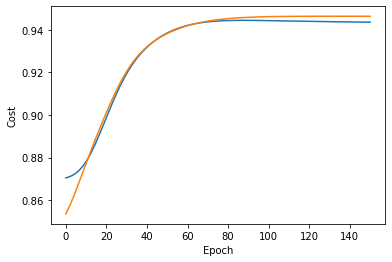

In [4]:
plt.plot(epochl, costs_t)
plt.plot(epochl, costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [10]:
#free param
n_data = 100
noisy_prop = [0, 10, 50, 100]
test_data = 30
lr = 0.5
epochs = 100
target_cost = 0.95



noise_perf = [[],[]]
for n_noise in noisy_prop:
    #init random unitaries
    U11 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U12 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U13 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U21 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
    U22 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
    
    #generate training data for random unitary
    V = qt.rand_unitary(4, dims=[[2,2], [2,2]])
    td= [[],[]]
    for i in range(n_data):
        rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
        #pins
        td[0].append(rs)
        rs = V*rs*V.dag()
        #pouts (train)
        td[1].append(rs)


    test = [[],[]]
    for i in range(test_data):
        rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
        #pins
        test[0].append(rs)
        rs = V*rs*V.dag()
        #pouts (train)
        test[1].append(rs)


    #add noisey data to training data
    for i in range(n_noise):
        V = qt.rand_unitary(4, dims=[[2,2], [2,2]])
        rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
        td[0].append(rs)
        rs = V*rs*V.dag()
        td[1].append(rs)

    

    pins = td[0]
    pints = []
    pouts = []
    for pin in pins:
        pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
        pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

    costs=[cost(pouts,td[1])]
    print(f'Initial Train Cost: {costs[0]}')

    pints_t = []
    pouts_t = []
    for pin in test[0]:
        pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
        pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

    costs_t = [cost(pouts_t,test[1])]
    print(f'Initial Test Cost:  {costs_t[0]}')
    

    print(f'Training with learning rate {lr}:')


    epochl = [0]
    epoch = 1

    for i in range(epochs):
        if cost(pouts,td[1])<target_cost:
            sigs=[]
            for pout in td[1]:
                sigs.append(adjoint_layer(pout, U21, U22))

            K11m=K11(pins, sigs, U11,U12,U13)
            K12m=K12(pins, sigs, U11,U12,U13)
            K13m=K13(pins, sigs, U11,U12,U13)
            Ko1m=Ko1(pints,td[1],U21,U22)
            Ko2m=Ko2(pints,td[1],U21,U22)

            U11 = (-lr*K11m).expm()*U11
            U12 = (-lr*K12m).expm()*U12
            U13 = (-lr*K13m).expm()*U13
            U21 = (-lr*Ko1m).expm()*U21
            U22 = (-lr*Ko2m).expm()*U22

            pints = []
            pouts = []
            for pin in pins:
                pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
                pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

            costs.append(cost(pouts,td[1]))
            print(f'Epoch {epoch}\n Train Cost: {costs[epoch]}')


            pints_t = []
            pouts_t = []
            for pin in test[0]:
                pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
                pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

            costs_t.append(cost(pouts_t,test[1]))
            print(f' Test Cost:  {costs_t[epoch]}')


            epochl.append(epoch)
            epoch+=1

        else:
            print(f'Target cost {target_cost} achieved')
            break
    noise_perf[0].append(n_noise)
    noise_perf[1].append(costs_t)
    print('Done with assigned task.')

Initial Train Cost: 0.8479057914242185
Initial Test Cost:  0.8240571438057429
Training with learning rate 0.5:
Epoch 1
 Train Cost: 0.8504468911534515
 Test Cost:  0.8260042738026768
Epoch 2
 Train Cost: 0.853201456636065
 Test Cost:  0.8282912715554742
Epoch 3
 Train Cost: 0.8561695974485106
 Test Cost:  0.830934562426048
Epoch 4
 Train Cost: 0.8593472672172117
 Test Cost:  0.8339424380216842
Epoch 5
 Train Cost: 0.8627262249435371
 Test Cost:  0.837313656344932
Epoch 6
 Train Cost: 0.8662938751595209
 Test Cost:  0.8410365551519413
Epoch 7
 Train Cost: 0.8700330345540291
 Test Cost:  0.845088974654778
Epoch 8
 Train Cost: 0.8739217869066803
 Test Cost:  0.8494391509790978
Epoch 9
 Train Cost: 0.877933565070084
 Test Cost:  0.8540474210957991
Epoch 10
 Train Cost: 0.8820374506446169
 Test Cost:  0.8588682151558975
Epoch 11
 Train Cost: 0.8861985512660348
 Test Cost:  0.8638516523232299
Epoch 12
 Train Cost: 0.8903783472692576
 Test Cost:  0.8689442768623982
Epoch 13
 Train Cost: 0.894

 Test Cost:  0.9482457389785277
Epoch 56
 Train Cost: 0.9295596301930652
 Test Cost:  0.9483620829019677
Epoch 57
 Train Cost: 0.9296525580513002
 Test Cost:  0.9484782401853742
Epoch 58
 Train Cost: 0.9297453537432165
 Test Cost:  0.9485945509471354
Epoch 59
 Train Cost: 0.9298381898698563
 Test Cost:  0.9487113122504272
Epoch 60
 Train Cost: 0.9299312174788473
 Test Cost:  0.948828783390909
Epoch 61
 Train Cost: 0.9300245687644074
 Test Cost:  0.9489471902862423
Epoch 62
 Train Cost: 0.9301183592476777
 Test Cost:  0.9490667291171334
Epoch 63
 Train Cost: 0.93021268953157
 Test Cost:  0.9491875693466888
Epoch 64
 Train Cost: 0.9303076467093349
 Test Cost:  0.9493098562256325
Epoch 65
 Train Cost: 0.9304033054936148
 Test Cost:  0.9494337128746663
Epoch 66
 Train Cost: 0.9304997291221432
 Test Cost:  0.9495592420214333
Epoch 67
 Train Cost: 0.9305969700873986
 Test Cost:  0.9496865274578439
Epoch 68
 Train Cost: 0.930695070729928
 Test Cost:  0.9498156352734367
Epoch 69
 Train Cost: 0

 Test Cost:  0.9429438962323171
Epoch 67
 Train Cost: 0.9056838372774739
 Test Cost:  0.9431121623806185
Epoch 68
 Train Cost: 0.9057709160239142
 Test Cost:  0.9432731382896317
Epoch 69
 Train Cost: 0.9058545615484939
 Test Cost:  0.9434273114656183
Epoch 70
 Train Cost: 0.9059349767868197
 Test Cost:  0.9435751316468486
Epoch 71
 Train Cost: 0.9060123502097166
 Test Cost:  0.9437170139700287
Epoch 72
 Train Cost: 0.9060868569763794
 Test Cost:  0.9438533418449292
Epoch 73
 Train Cost: 0.9061586599822246
 Test Cost:  0.9439844695677054
Epoch 74
 Train Cost: 0.9062279108134479
 Test Cost:  0.9441107246998377
Epoch 75
 Train Cost: 0.9062947506184956
 Test Cost:  0.9442324102363663
Epoch 76
 Train Cost: 0.9063593109051878
 Test Cost:  0.9443498065845094
Epoch 77
 Train Cost: 0.9064217142711115
 Test Cost:  0.9444631733711905
Epoch 78
 Train Cost: 0.9064820750737937
 Test Cost:  0.9445727510960041
Epoch 79
 Train Cost: 0.9065405000464344
 Test Cost:  0.9446787626442839
Epoch 80
 Train Cos

 Test Cost:  0.9392533203960701
Epoch 78
 Train Cost: 0.8957984093390953
 Test Cost:  0.9395775811135644
Epoch 79
 Train Cost: 0.8959448170360136
 Test Cost:  0.9398885569930502
Epoch 80
 Train Cost: 0.8960852677394198
 Test Cost:  0.9401868550323068
Epoch 81
 Train Cost: 0.8962200059254869
 Test Cost:  0.9404730565860172
Epoch 82
 Train Cost: 0.8963492679021624
 Test Cost:  0.9407477178523924
Epoch 83
 Train Cost: 0.896473281779051
 Test Cost:  0.9410113704451446
Epoch 84
 Train Cost: 0.8965922674877753
 Test Cost:  0.9412645220353512
Epoch 85
 Train Cost: 0.8967064368452882
 Test Cost:  0.9415076570485594
Epoch 86
 Train Cost: 0.8968159936533538
 Test Cost:  0.9417412374049862
Epoch 87
 Train Cost: 0.8969211338282235
 Test Cost:  0.9419657032902138
Epoch 88
 Train Cost: 0.8970220455551988
 Test Cost:  0.9421814739479629
Epoch 89
 Train Cost: 0.8971189094634194
 Test Cost:  0.9423889484843789
Epoch 90
 Train Cost: 0.8972118988167566
 Test Cost:  0.9425885066779783
Epoch 91
 Train Cost

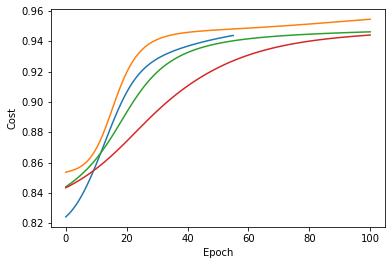

In [21]:

for i in range(0,len(noise_perf[0]),2):
    
    plt.plot([i for i in range(len(noise_perf[0][i+1]))], noise_perf[0][i+1])
    
    
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [27]:
#free param
n_datas = [5, 10, 25, 50]
test_data = 50
lr = 0.5
epochs = 60
target_cost = 0.99



sm_perf = [[],[]]
for n_data in n_datas:
    #init random unitaries
    U11 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U12 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U13 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U21 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
    U22 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
    
    #generate training data for random unitary
    V = qt.rand_unitary(4, dims=[[2,2], [2,2]])
    td= [[],[]]
    for i in range(n_data):
        rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
        #pins
        td[0].append(rs)
        rs = V*rs*V.dag()
        #pouts (train)
        td[1].append(rs)


    test = [[],[]]
    for i in range(test_data):
        rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
        #pins
        test[0].append(rs)
        rs = V*rs*V.dag()
        #pouts (train)
        test[1].append(rs)



    

    pins = td[0]
    pints = []
    pouts = []
    for pin in pins:
        pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
        pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

    costs=[cost(pouts,td[1])]
    print(f'Initial Train Cost: {costs[0]}')

    pints_t = []
    pouts_t = []
    for pin in test[0]:
        pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
        pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

    costs_t = [cost(pouts_t,test[1])]
    print(f'Initial Test Cost:  {costs_t[0]}')
    

    print(f'Training with learning rate {lr}:')


    epochl = [0]
    epoch = 1

    for i in range(epochs):
        if cost(pouts,td[1])<target_cost:
            sigs=[]
            for pout in td[1]:
                sigs.append(adjoint_layer(pout, U21, U22))

            K11m=K11(pins, sigs, U11,U12,U13)
            K12m=K12(pins, sigs, U11,U12,U13)
            K13m=K13(pins, sigs, U11,U12,U13)
            Ko1m=Ko1(pints,td[1],U21,U22)
            Ko2m=Ko2(pints,td[1],U21,U22)

            U11 = (-lr*K11m).expm()*U11
            U12 = (-lr*K12m).expm()*U12
            U13 = (-lr*K13m).expm()*U13
            U21 = (-lr*Ko1m).expm()*U21
            U22 = (-lr*Ko2m).expm()*U22

            pints = []
            pouts = []
            for pin in pins:
                pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
                pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

            costs.append(cost(pouts,td[1]))
            print(f'Epoch {epoch}\n Train Cost: {costs[epoch]}')


            pints_t = []
            pouts_t = []
            for pin in test[0]:
                pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
                pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

            costs_t.append(cost(pouts_t,test[1]))
            print(f' Test Cost:  {costs_t[epoch]}')


            epochl.append(epoch)
            epoch+=1

        else:
            print(f'Target cost {target_cost} achieved')
            break
    sm_perf[0].append(n_data)
    sm_perf[1].append(costs_t)
    print('Done with assigned task.')

Initial Train Cost: 0.8994885489991775
Initial Test Cost:  0.8356611107502644
Training with learning rate 0.5:
Epoch 1
 Train Cost: 0.9078882961706196
 Test Cost:  0.8335663289526152
Epoch 2
 Train Cost: 0.914748715325629
 Test Cost:  0.830532394983301
Epoch 3
 Train Cost: 0.9199434515283038
 Test Cost:  0.8267158306710165
Epoch 4
 Train Cost: 0.9234600926536386
 Test Cost:  0.822343870966366
Epoch 5
 Train Cost: 0.9254113273788745
 Test Cost:  0.8176747255274971
Epoch 6
 Train Cost: 0.9260124333102131
 Test Cost:  0.8129455759514052
Epoch 7
 Train Cost: 0.9255332815733257
 Test Cost:  0.8083327431944483
Epoch 8
 Train Cost: 0.9242481114771105
 Test Cost:  0.8039404941814453
Epoch 9
 Train Cost: 0.9224011772417076
 Test Cost:  0.799814538565704
Epoch 10
 Train Cost: 0.9201916422670705
 Test Cost:  0.7959644448227857
Epoch 11
 Train Cost: 0.9177720586766086
 Test Cost:  0.7923824673100994
Epoch 12
 Train Cost: 0.9152538300133778
 Test Cost:  0.7890548863994279
Epoch 13
 Train Cost: 0.91

Epoch 51
 Train Cost: 0.9324180944601346
 Test Cost:  0.8771158434179931
Epoch 52
 Train Cost: 0.9324757251590411
 Test Cost:  0.8771555228317723
Epoch 53
 Train Cost: 0.9325254430160428
 Test Cost:  0.8771851971734025
Epoch 54
 Train Cost: 0.9325680225603676
 Test Cost:  0.877205924445944
Epoch 55
 Train Cost: 0.9326041620720478
 Test Cost:  0.8772186502114243
Epoch 56
 Train Cost: 0.9326344883516882
 Test Cost:  0.8772242152127797
Epoch 57
 Train Cost: 0.9326595616379043
 Test Cost:  0.8772233630917914
Epoch 58
 Train Cost: 0.932679880571043
 Test Cost:  0.8772167480785433
Epoch 59
 Train Cost: 0.9326958871186259
 Test Cost:  0.8772049425476591
Epoch 60
 Train Cost: 0.9327079713936371
 Test Cost:  0.8771884443555483
Done with assigned task.
Initial Train Cost: 0.8522911158745238
Initial Test Cost:  0.8486869060042826
Training with learning rate 0.5:
Epoch 1
 Train Cost: 0.8563973230609571
 Test Cost:  0.8488181007448947
Epoch 2
 Train Cost: 0.8601611403212825
 Test Cost:  0.848783725

 Test Cost:  0.951724399690204
Epoch 41
 Train Cost: 0.9589630930697953
 Test Cost:  0.9518903162367458
Epoch 42
 Train Cost: 0.9590725996724088
 Test Cost:  0.9520422296384066
Epoch 43
 Train Cost: 0.9591750466014246
 Test Cost:  0.9521818103293658
Epoch 44
 Train Cost: 0.9592713529500756
 Test Cost:  0.9523105089148587
Epoch 45
 Train Cost: 0.9593623093493575
 Test Cost:  0.9524295883764756
Epoch 46
 Train Cost: 0.9594485975125397
 Test Cost:  0.9525401510303992
Epoch 47
 Train Cost: 0.959530806471264
 Test Cost:  0.9526431611643672
Epoch 48
 Train Cost: 0.9596094461144392
 Test Cost:  0.9527394641092798
Epoch 49
 Train Cost: 0.9596849585220634
 Test Cost:  0.9528298023617293
Epoch 50
 Train Cost: 0.9597577274906856
 Test Cost:  0.9529148292607381
Epoch 51
 Train Cost: 0.9598280865707497
 Test Cost:  0.9529951206300723
Epoch 52
 Train Cost: 0.9598963258748329
 Test Cost:  0.9530711847227745
Epoch 53
 Train Cost: 0.959962697866784
 Test Cost:  0.9531434707438944
Epoch 54
 Train Cost: 

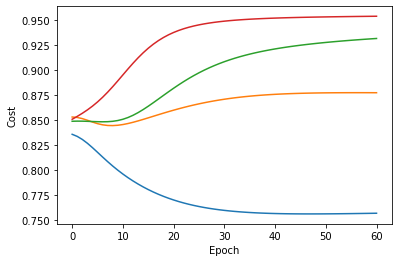

In [28]:
for costs_t in sm_perf[1]:
    plt.plot(epochl, costs_t)
    
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [37]:
#free param
n_data = 50
n_noise = 0
test_data = 1
lrs = [1, 0.5, 0.25, 0.1]
epochs = 150
target_cost = 0.99


#generate training data for random unitary
V = qt.rand_unitary(4, dims=[[2,2], [2,2]])
td= [[],[]]
for i in range(n_data):
    rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
    #pins
    td[0].append(rs)
    rs = V*rs*V.dag()
    #pouts (train)
    td[1].append(rs)


test = [[],[]]
for i in range(test_data):
    rs = qt.rand_dm(4, 1, dims=[[2,2], [2,2]])
    #pins
    test[0].append(rs)
    rs = V*rs*V.dag()
    #pouts (train)
    test[1].append(rs)

lr_perf = [[],[]]
for lr in lrs:
    #init random unitaries
    U11 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U12 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U13 = qt.rand_unitary(8, dims=[[2,2,2], [2,2,2]])
    U21 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
    U22 = qt.rand_unitary(16, dims=[[2,2,2,2], [2,2,2,2]])
    


    

    pins = td[0]
    pints = []
    pouts = []
    for pin in pins:
        pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
        pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

    costs=[cost(pouts,td[1])]
    print(f'Initial Train Cost: {costs[0]}')

    pints_t = []
    pouts_t = []
    for pin in test[0]:
        pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
        pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

    costs_t = [cost(pouts_t,test[1])]
    print(f'Initial Test Cost:  {costs_t[0]}')
    

    print(f'Training with learning rate {lr}:')


    epochl = [0]
    epoch = 1

    for i in range(epochs):
        if cost(pouts,td[1])<target_cost:
            sigs=[]
            for pout in td[1]:
                sigs.append(adjoint_layer(pout, U21, U22))

            K11m=K11(pins, sigs, U11,U12,U13)
            K12m=K12(pins, sigs, U11,U12,U13)
            K13m=K13(pins, sigs, U11,U12,U13)
            Ko1m=Ko1(pints,td[1],U21,U22)
            Ko2m=Ko2(pints,td[1],U21,U22)

            U11 = (-lr*K11m).expm()*U11
            U12 = (-lr*K12m).expm()*U12
            U13 = (-lr*K13m).expm()*U13
            U21 = (-lr*Ko1m).expm()*U21
            U22 = (-lr*Ko2m).expm()*U22

            pints = []
            pouts = []
            for pin in pins:
                pints.append(forward(U11,U12,U13,U21,U22,pin)[1])
                pouts.append(forward(U11,U12,U13,U21,U22,pin)[2])

            costs.append(cost(pouts,td[1]))
            print(f'Epoch {epoch}\n Train Cost: {costs[epoch]}')


            pints_t = []
            pouts_t = []
            for pin in test[0]:
                pints_t.append(forward(U11,U12,U13,U21,U22,pin)[1])
                pouts_t.append(forward(U11,U12,U13,U21,U22,pin)[2])

            costs_t.append(cost(pouts_t,test[1]))
            print(f' Test Cost:  {costs_t[epoch]}')


            epochl.append(epoch)
            epoch+=1

        else:
            print(f'Target cost {target_cost} achieved')
            break
    lr_perf[0].append(n_data)
    lr_perf[1].append(costs)
    print('Done with assigned task.')

Initial Train Cost: 0.8524690027108598
Initial Test Cost:  0.8084275086656372
Training with learning rate 1:
Epoch 1
 Train Cost: 0.8596807745015645
 Test Cost:  0.8157652128952035
Epoch 2
 Train Cost: 0.8667357373942535
 Test Cost:  0.8236819574833337
Epoch 3
 Train Cost: 0.8735026505092123
 Test Cost:  0.8323381046495635
Epoch 4
 Train Cost: 0.8798870023935368
 Test Cost:  0.8417260640058675
Epoch 5
 Train Cost: 0.8858749945781689
 Test Cost:  0.8516036844806567
Epoch 6
 Train Cost: 0.8915268453116555
 Test Cost:  0.8615524165791875
Epoch 7
 Train Cost: 0.8969140397118185
 Test Cost:  0.8711344910852301
Epoch 8
 Train Cost: 0.9020609997816201
 Test Cost:  0.8800201328468813
Epoch 9
 Train Cost: 0.9069369866799671
 Test Cost:  0.8880183088927116
Epoch 10
 Train Cost: 0.9114838958431094
 Test Cost:  0.8950513605392618
Epoch 11
 Train Cost: 0.9156466132267822
 Test Cost:  0.9011217175150996
Epoch 12
 Train Cost: 0.9193905647780077
 Test Cost:  0.9062855209208611
Epoch 13
 Train Cost: 0.

Epoch 112
 Train Cost: 0.9493375985198251
 Test Cost:  0.9586714245795227
Epoch 113
 Train Cost: 0.9493260051907769
 Test Cost:  0.9586884431108105
Epoch 114
 Train Cost: 0.9493148019032445
 Test Cost:  0.9587046607935648
Epoch 115
 Train Cost: 0.9493039859526583
 Test Cost:  0.9587201270336121
Epoch 116
 Train Cost: 0.9492935540370124
 Test Cost:  0.9587348885032272
Epoch 117
 Train Cost: 0.9492835023307656
 Test Cost:  0.9587489892759395
Epoch 118
 Train Cost: 0.9492738265526949
 Test Cost:  0.9587624709566035
Epoch 119
 Train Cost: 0.9492645220280518
 Test Cost:  0.9587753728066611
Epoch 120
 Train Cost: 0.9492555837454013
 Test Cost:  0.9587877318645479
Epoch 121
 Train Cost: 0.9492470064084604
 Test Cost:  0.9587995830612318
Epoch 122
 Train Cost: 0.9492387844832927
 Test Cost:  0.958810959330896
Epoch 123
 Train Cost: 0.9492309122411582
 Test Cost:  0.9588218917168236
Epoch 124
 Train Cost: 0.9492233837973472
 Test Cost:  0.9588324094725482
Epoch 125
 Train Cost: 0.94921619314626

Epoch 73
 Train Cost: 0.9589422579415754
 Test Cost:  0.9580623651759317
Epoch 74
 Train Cost: 0.9590096537594788
 Test Cost:  0.9580415968017844
Epoch 75
 Train Cost: 0.9590752994348395
 Test Cost:  0.9580212280208567
Epoch 76
 Train Cost: 0.9591392396316476
 Test Cost:  0.9580012329952177
Epoch 77
 Train Cost: 0.9592015176196079
 Test Cost:  0.9579815862393073
Epoch 78
 Train Cost: 0.9592621753905486
 Test Cost:  0.9579622628395454
Epoch 79
 Train Cost: 0.9593212537581534
 Test Cost:  0.9579432386266777
Epoch 80
 Train Cost: 0.959378792443232
 Test Cost:  0.9579244903078161
Epoch 81
 Train Cost: 0.9594348301464766
 Test Cost:  0.9579059955642365
Epoch 82
 Train Cost: 0.9594894046103829
 Test Cost:  0.9578877331202289
Epoch 83
 Train Cost: 0.9595425526718365
 Test Cost:  0.9578696827876119
Epoch 84
 Train Cost: 0.9595943103066444
 Test Cost:  0.9578518254899062
Epoch 85
 Train Cost: 0.9596447126671791
 Test Cost:  0.9578341432696875
Epoch 86
 Train Cost: 0.9596937941141127
 Test Cost:

Epoch 34
 Train Cost: 0.9077704972327222
 Test Cost:  0.8898284566202637
Epoch 35
 Train Cost: 0.9090265673995289
 Test Cost:  0.8915604800816606
Epoch 36
 Train Cost: 0.9102566162452993
 Test Cost:  0.8932662062451018
Epoch 37
 Train Cost: 0.9114614186612048
 Test Cost:  0.8949427362798418
Epoch 38
 Train Cost: 0.9126416793075738
 Test Cost:  0.896587763367634
Epoch 39
 Train Cost: 0.9137980220327054
 Test Cost:  0.8981995061741797
Epoch 40
 Train Cost: 0.914930986378335
 Test Cost:  0.8997766432388661
Epoch 41
 Train Cost: 0.916041029592245
 Test Cost:  0.9013182503376573
Epoch 42
 Train Cost: 0.9171285326883968
 Test Cost:  0.9028237421924998
Epoch 43
 Train Cost: 0.9181938092637524
 Test Cost:  0.9042928193464148
Epoch 44
 Train Cost: 0.919237115972979
 Test Cost:  0.9057254205896759
Epoch 45
 Train Cost: 0.9202586637593824
 Test Cost:  0.9071216809966072
Epoch 46
 Train Cost: 0.9212586291304163
 Test Cost:  0.9084818953991107
Epoch 47
 Train Cost: 0.9222371649410863
 Test Cost:  0

Epoch 147
 Train Cost: 0.9578751134831391
 Test Cost:  0.9552927882490075
Epoch 148
 Train Cost: 0.957961892687368
 Test Cost:  0.9553923417952019
Epoch 149
 Train Cost: 0.9580468412436177
 Test Cost:  0.9554895294624691
Epoch 150
 Train Cost: 0.9581300031307934
 Test Cost:  0.9555844139396357
Done with assigned task.
Initial Train Cost: 0.8531058988991805
Initial Test Cost:  0.8785332794265821
Training with learning rate 0.1:
Epoch 1
 Train Cost: 0.8541889557288991
 Test Cost:  0.8797160468564663
Epoch 2
 Train Cost: 0.8552743188170606
 Test Cost:  0.8808724627710017
Epoch 3
 Train Cost: 0.8563614268726084
 Test Cost:  0.8820019598330733
Epoch 4
 Train Cost: 0.8574497260367427
 Test Cost:  0.8831041008648783
Epoch 5
 Train Cost: 0.8585386757386235
 Test Cost:  0.8841785881352695
Epoch 6
 Train Cost: 0.8596277544764811
 Test Cost:  0.8852252713657511
Epoch 7
 Train Cost: 0.8607164654071625
 Test Cost:  0.8862441542438964
Epoch 8
 Train Cost: 0.8618043416256838
 Test Cost:  0.8872353992

Epoch 108
 Train Cost: 0.9383756432620185
 Test Cost:  0.942938408046617
Epoch 109
 Train Cost: 0.9386170314105031
 Test Cost:  0.9430434606378914
Epoch 110
 Train Cost: 0.938852059986015
 Test Cost:  0.9431443324137483
Epoch 111
 Train Cost: 0.9390809358774176
 Test Cost:  0.9432412643114844
Epoch 112
 Train Cost: 0.9393038597437423
 Test Cost:  0.9433344863897652
Epoch 113
 Train Cost: 0.939521026098416
 Test Cost:  0.9434242181182021
Epoch 114
 Train Cost: 0.9397326234053034
 Test Cost:  0.9435106686820447
Epoch 115
 Train Cost: 0.9399388341847689
 Test Cost:  0.9435940372984553
Epoch 116
 Train Cost: 0.940139835128128
 Test Cost:  0.9436745135412319
Epoch 117
 Train Cost: 0.940335797219041
 Test Cost:  0.9437522776711961
Epoch 118
 Train Cost: 0.9405268858605099
 Test Cost:  0.943827500969758
Epoch 119
 Train Cost: 0.9407132610063127
 Test Cost:  0.9439003460735215
Epoch 120
 Train Cost: 0.9408950772957959
 Test Cost:  0.9439709673080061
Epoch 121
 Train Cost: 0.9410724841910988
 T

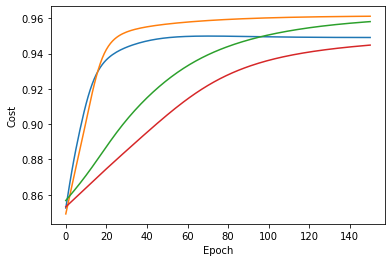

In [38]:
for costs_t in lr_perf[1]:
    plt.plot(epochl, costs_t)
    
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()